In [7]:
import sys
import os
import glob
import random
import copy
from IPython.display import display, Markdown
sys.path.append('../..')

from model import processing
from matplotlib import pyplot as plt

from model import run
from model import plot_utils as pu
from model.amm.omnipool_amm import OmnipoolState, cash_out_omnipool, value_assets, usd_price, lrna_price
from model.amm.stableswap_amm import StableSwapPoolState
from model.amm.agents import Agent
from model.amm.trade_strategies import omnipool_arbitrage, invest_all, price_sensitive_trading
from model.amm.global_state import GlobalState, fluctuate_prices, historical_prices

# same seed, same parameters = same simulation result
random.seed(42)
# price_list = processing.import_binance_prices(['BTC', 'ETH', 'DOT'], start_date='Jan 1 2023', days = 120)

assets = {
    'USDA': {'usd price': 1, 'weight': 0.25},
    'USDB': {'usd price': 1, 'weight': 0.25},
    'USDC': {'usd price': 1, 'weight': 0.25},
    'USDD': {'usd price': 1, 'weight': 0.25},
}

assert sum([t['weight'] for t in assets.values()]) == 1

initial_tvl = 2000000

initial_state = GlobalState(
    pools={
        'stableswap': StableSwapPoolState(
            tokens={
                tkn: initial_tvl * assets[tkn]['weight'] for tkn in assets
            },
            amplification=100,
            trade_fee=0
        )
    },
    agents = {
        'Trader': Agent(
            holdings={tkn: 10000000000000 for tkn in assets}
        )
    },
    # external_market={tkn: assets[tkn]['usd price'] for tkn in assets},
    # archive_all=False
)

In [8]:
amps = [100, 200, 320, 500, 1000]

amps.sort()  # required
max_trade = 400000
steps = 100
max_i = 10000
price_band = 0.1
amp_events = []
amounts = []
spot_prices = []
spot_prices_2 = []
for i, amplification in enumerate(amps):
    initial_state.pools['stableswap'].amplification = amplification
    trade_size_min, trade_size_max = -max_trade, max_trade
    trade_sizes = [trade_size_min + i * (trade_size_max - trade_size_min) / steps for i in range(steps)]
    
    step_size = 1000
    trade_size = 0
    spot_price = 1
    i = 0
    amts = []
    prices = []
    prices2 = []
    # for trade_size in trade_sizes:
    while spot_price <= 1 + price_band and i < max_i:
        i += 1
        # trade to change the price of assets. 
        # We assume that whatever the resulting price is the new market price, and the trade is an arb trade.
        
        amm_state = copy.deepcopy(initial_state.pools['stableswap'])
        agent = copy.deepcopy(initial_state.agents['Trader'])
        
        amm_state.swap_one(
                agent=agent,
                tkn_buy='USDB',
                quantity=max(abs(trade_size), 0),
            )
                
        spot_price = amm_state.spot_price(1)
        prices2.append(amm_state.spot_price(2))
        prices.append(spot_price)
        amts.append(amm_state.liquidity['USDB'])
        
        trade_size += step_size
        
    trade_size = step_size
    i = 0
    while spot_price >= 1 - price_band and i < max_i:
        i += 1
        # trade to change the price of assets. 
        # We assume that whatever the resulting price is the new market price, and the trade is an arb trade.
        
        amm_state = copy.deepcopy(initial_state.pools['stableswap'])
        agent = copy.deepcopy(initial_state.agents['Trader'])
        
        amm_state.swap_one(
                agent=agent,
                tkn_sell='USDB',
                quantity=max(abs(trade_size), 0),
            )
        
        spot_price = amm_state.spot_price(1)
        prices.append(spot_price)
        prices2.append(amm_state.spot_price(2))
        amts.append(amm_state.liquidity['USDB'])
        
        trade_size += step_size
    
    spot_prices.append(prices)
    spot_prices_2.append(prices2)
    amounts.append(amts)
    
print('simulation finished.')

simulation finished.


In [9]:
tenth_percentile = []
twentieth_percentile = []
eightieth_percentile = []
ninetieth_percentile = []
for i, amp in enumerate(amps):
    amt_ls = amounts[i]
    price_ls = spot_prices[i]
    pairs = [(spot_prices[i][j], amounts[i][j]) for j in range(len(amounts[i]))]
    pairs.sort(key=lambda pair: pair[0])
    amt_ls = [pair[1] for pair in pairs]
    price_ls = [pair[0] for pair in pairs]
    tenth = []
    twentieth = []
    eightieth = []
    ninetieth = []
    for j in range(len(amt_ls) - 1):
        if amt_ls[j] >= 1500000 and amt_ls[j+1] < 1500000:
            ninetieth.append((price_ls[j], amt_ls[j]))
        if amt_ls[j] >= 1200000 and amt_ls[j+1] < 1200000:
            eightieth.append((price_ls[j], amt_ls[j]))
        if amt_ls[j] >= 100000 and amt_ls[j+1] < 100000:
            twentieth.append((price_ls[j], amt_ls[j]))
        if amt_ls[j] >= 50000 and amt_ls[j+1] < 50000:
            tenth.append((price_ls[j], amt_ls[j]))
            break
    tenth_percentile.append(tenth)
    twentieth_percentile.append(twentieth)
    eightieth_percentile.append(eightieth)
    ninetieth_percentile.append(ninetieth)

print('90th percentile: ')

90th percentile: 


amp:  100
100k USDB:  1.0967076490238492
1.6m USDB:  0.963269985235443
amp:  200
100k USDB:  1.049473641222971
1.6m USDB:  0.9808819756638427
1.8m USDB:  0.9059292886817807
amp:  320
100k USDB:  1.031901454286454
1.6m USDB:  0.9877582423977362
1.8m USDB:  0.9359399112122693
amp:  500
50k USDB:  1.0814209193806834
100k USDB:  1.0196212430834177
1.6m USDB:  0.992116139836888
1.8m USDB:  0.9568934418481865
amp:  1000
50k USDB:  1.0390525754979458
100k USDB:  1.009976922234495
1.6m USDB:  0.9959791772099638
1.8m USDB:  0.9768567438911393


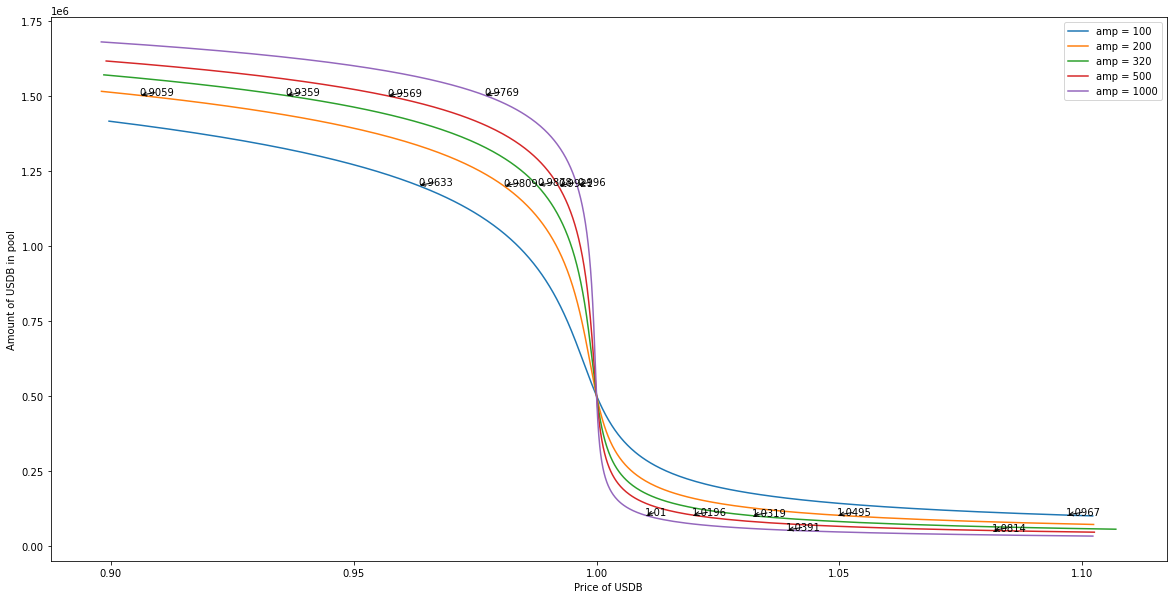

In [10]:

    
plt.figure(figsize=(20,10))

for i in range(len(amounts)):
    pairs = [(spot_prices[i][j], amounts[i][j]) for j in range(len(amounts[i]))]
    pairs.sort(key=lambda pair: pair[0])
    plt.plot([pair[0] for pair in pairs], [pair[1] for pair in pairs], label=f'amp = {amps[i]}')
    print("amp: ", amps[i])
    for pair in tenth_percentile[i]:
        plt.annotate(
            xy=pair,
            xytext=(pair[0], pair[1]),
            text=f"{round(pair[0], 4)}",
            arrowprops={'arrowstyle': '->', 'relpos': (0.5, 0.5)}
        )
        print("50k USDB: ", pair[0])
    for pair in twentieth_percentile[i]:
        plt.annotate(
            xy=pair,
            xytext=(pair[0], pair[1]),
            text=f"{round(pair[0], 4)}",
            arrowprops={'arrowstyle': '->', 'relpos': (0.5, 0.5)}
        )
        print("100k USDB: ", pair[0])
    for pair in eightieth_percentile[i]:
        plt.annotate(
            xy=pair,
            xytext=(pair[0], pair[1]),
            text=f"{round(pair[0], 4)}",
            arrowprops={'arrowstyle': '->', 'relpos': (0.5, 0.5)}
        )
        print("1.6m USDB: ", pair[0])
    for pair in ninetieth_percentile[i]:
        plt.annotate(
            xy=pair,
            xytext=(pair[0], pair[1]),
            text=f"{round(pair[0], 4)}",
            arrowprops={'arrowstyle': '->', 'relpos': (0.5, 0.5)}
        )
        print("1.8m USDB: ", pair[0])
    
plt.legend()
plt.xlabel("Price of USDB")
plt.ylabel("Amount of USDB in pool")

plt.show()



amp:  100
amp:  200
amp:  320
amp:  500
amp:  1000
0.9941615368762318 -33355992.867389478
1.008884937122395 -5684435.017195235


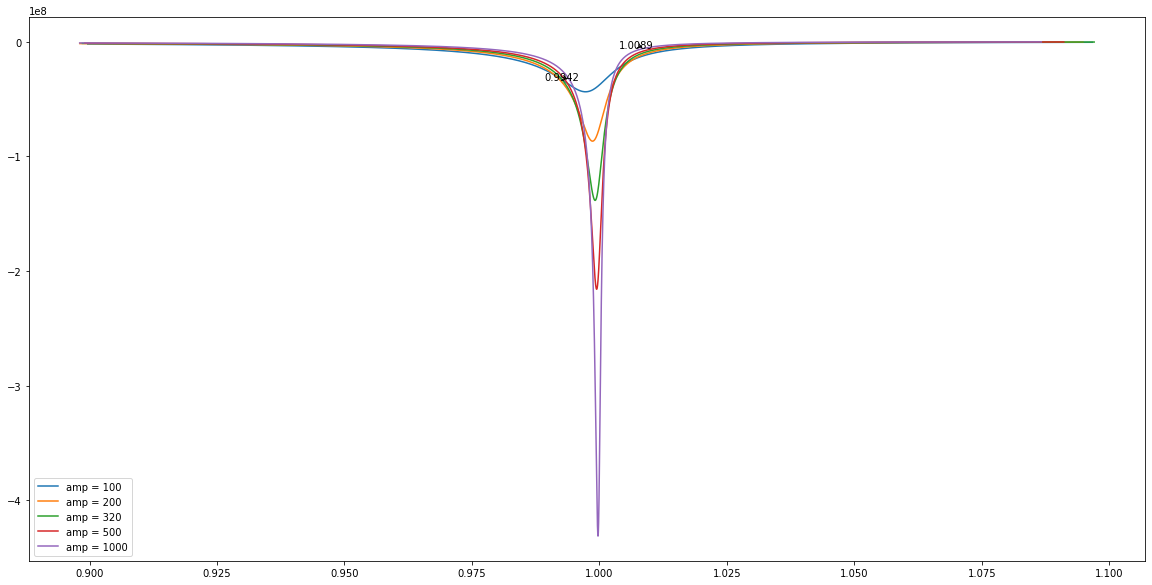

In [11]:
sorted_prices = []
sorted_amounts = []
for i in range(len(amounts)):
    pairs = [(spot_prices[i][j], amounts[i][j]) for j in range(len(amounts[i]))]
    pairs.sort(key=lambda pair: pair[0])
    sorted_prices.append([pair[0] for pair in pairs])
    sorted_amounts.append([pair[1] for pair in pairs])

plt.figure(figsize=(20,10))



diffs = []
for i in range(len(amps)):
    diffs.append([sorted_amounts[i][j+1] - sorted_amounts[i][j] for j in range(len(sorted_amounts[i]) - 1)])
    prices = sorted_prices[i]
    normed_diffs = [diffs[-1][j]/(prices[j+1]-prices[j]) for j in range(len(diffs[-1]))]
    prices.pop()
    plt.plot(prices, normed_diffs, label=f'amp = {amps[i]}')
    k_ls = [130, 520]
    print("amp: ", amps[i])
    for k in k_ls:
        if i == len(amps) - 1 and k < len(prices):
            print(prices[k],normed_diffs[k])
            plt.annotate(
                    xy=(prices[k],normed_diffs[k]),
                    xytext=(prices[k]-0.005,normed_diffs[k]),
                    text=f"{round(prices[k], 4)}",
                    arrowprops={'arrowstyle': '->', 'relpos': (0.5, 0.5)}
                )
    
plt.legend()
# plt.xlabel("Price of USDB")
# plt.ylabel("Amount of USDB in pool")

plt.show()


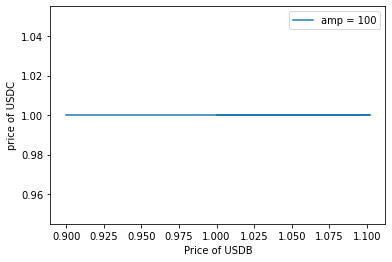

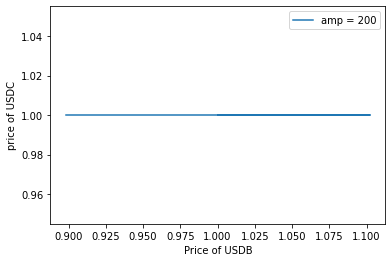

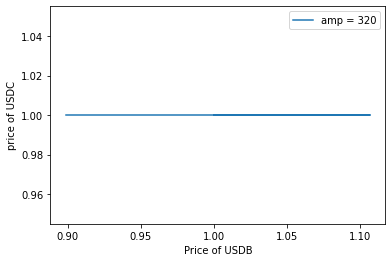

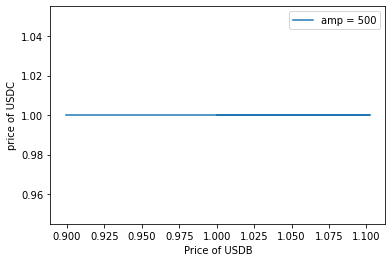

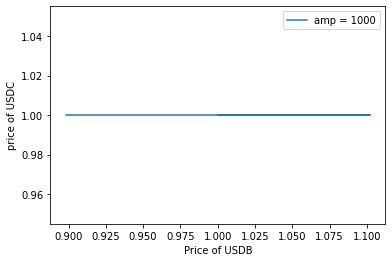

In [12]:

    

for i in range(len(amounts)):
    plt.plot(spot_prices[i], spot_prices_2[i], label=f'amp = {amps[i]}')

    
    plt.legend()
    plt.xlabel("Price of USDB")
    plt.ylabel("price of USDC")
    
    plt.show()

